[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_tts/interspeech2019_tts.ipynb)

# [T6] Advanced methods for neural end-to-end speech processing - unification, integration, and implementation -

### Part4 : Building End-to-End TTS System

Speaker: [**Tomoki Hayashi**](https://github.com/kan-bayashi)

Department of informatics, Nagoya University  
Human Dataware Lab. Co., Ltd.


## Google colaboratory

- Online Jupyter notebook environment
    - Can run python codes
    - Can also run linux command with ! mark
    - Can use a signal GPU (K80)
- What you need to use
    - Internet connection
    - Google account
    - Chrome browser (recommended)

## Usage of Google colaboratory

<div align=center>
    <img src=https://github.com/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_tts/figs/colab_usage.png?raw=1 width=80%>
</div>

- Do not close the browser
- Do not sleep your laptop

In [1]:
# example of the commands
print("hello, world.")
!echo "hello, world"

hello, world.
hello, world


## TOC

0. Installation
1. Introduction of ESPnet TTS
2. Demonstration of the ESPnet TTS recipe
3. Demonstration of the use of TTS pretrained models
4. Demonstration of the use of ASR pretrained models
5. Conclusion

## 0. Installation
 
It takes around 3 minutes. Please keep waiting for a while.


In [1]:
# OS setup
!cat /etc/os-release
!apt-get install -qq bc tree sox

# espnet setup
!pip install chainer==6.0.0
!git clone --depth 5 https://github.com/espnet/espnet -b v.0.9.7
!cd espnet; pip install -q -e .

# download pre-compiled warp-ctc and kaldi tools
!espnet/utils/download_from_google_drive.sh \
    "https://drive.google.com/open?id=13Y4tSygc8WtqzvAVGK_vRV9GlV7TRC0w" espnet/tools tar.gz > /dev/null
!cd espnet/tools && bash installers/install_sph2pipe.sh

# make dummy activate
!rm espnet/tools/activate_python.sh && touch espnet/tools/activate_python.sh
!echo "setup done."

NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic
  Using cached protobuf-3.7.1-cp37-cp37m-manylinux1_x86_64.whl (1.2 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.0
    Uninstalling protobuf-3.20.0:
      Successfully uninstalled protobuf-3.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
wandb 0.12.14 requires protobuf>=3.12.0, but you have protobuf 3.7.1 which is incompatible.
tensorflow 2.8.0 re

fatal: destination path 'espnet' already exists and is not an empty directory.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
chainer 6.0.0 requires protobuf<3.8.0rc1,>=3.0.0, but you have protobuf 3.20.0 which is incompatible.
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13Y4tSygc8WtqzvAVGK_vRV9GlV7TRC0w
To: /content/espnet/tools/ZSOyEk.tar.gz
100% 694M/694M [00:06<00:00, 108MB/s] 
file_headers.c: In function ‘readSphHeader’:
file_headers.c:148:59: warning: format ‘%d’ expects argument of type ‘int’, but argument 5 has type ‘__off_t {aka lon

## 1. Introduction of ESPnet TTS

- Follow the [Kaldi](https://github.com/kaldi-asr/kaldi) style recipe
- Support three E2E-TTS models and their variants
- Support four corpus including English, Japanese, Italy, Spanish, and Germany
- Support pretrained WaveNet-vocoder (Softmax and MoL version)

Samples are available in https://espnet.github.io/espnet-tts-sample/

### Supported E2E-TTS models

- [**Tacotron 2**](https://arxiv.org/abs/1712.05884): Standard Tacontron 2
- [**Multi-speaker Tacotron2**](https://arxiv.org/pdf/1806.04558.pdf): Pretrained speaker embedding (X-vector) + Tacotron 2
- [**Transformer**](https://arxiv.org/pdf/1809.08895.pdf): TTS-Transformer
- [**Multi-speaker Transformer**](): Pretrained speaker embedding (X-vector) + TTS-Transformer
- [**FastSpeech**](https://arxiv.org/pdf/1905.09263.pdf): Feed-forward TTS-Transformer


### Other remarkable functions

- [**CBHG** (Convolutional Bank Highway network Gated recurrent unit)](https://arxiv.org/pdf/1703.10135.pdf): Network to convert Mel-filter bank to linear spectrogram
- [**Forward attention**](https://arxiv.org/pdf/1807.06736.pdf): Attention mechanism with causal regularization
- [**Guided attention loss**](https://arxiv.org/pdf/1710.08969.pdf): Loss function to force attention to be diagonal

### Supported corpora

- [`egs/jsut/tts1`](https://sites.google.com/site/shinnosuketakamichi/publication/jsut): Japanese single female speaker. (48 kHz, ~10 hours)
- [`egs/libritts/tts1`](http://www.openslr.org/60/): English multi speakers (24 kHz, ~500 hours).
- [`egs/ljspeech/tts1`](https://keithito.com/LJ-Speech-Dataset/): English single female speaker (22.05 kHz, ~24 hours).
- [`egs/m_ailabs/tts1`](https://www.caito.de/2019/01/the-m-ailabs-speech-dataset/): Various language speakers (16 kHz, 16~48 hours).

## 2. Demonstration of ESPnet-TTS recipes
 
Here use the recipe `egs/an4/tts1` as an example.  

Unfortunately, `egs/an4/tts1` is too small to train,
but the flow itself is the same as the other recipes.

Always we organize each recipe placed in `egs/xxx/tts1` in the same manner:

- `run.sh`: Main script of the recipe.
- `cmd.sh`: Command configuration script to control how-to-run each job.
- `path.sh`: Path configuration script. Basically, we do not need to touch.
- `conf/`: Directory containing configuration files e.g.g.
- `local/`: Directory containing the recipe-specific scripts e.g. data preparation.
- `steps/` and `utils/`: Directory containing kaldi tools.

In [15]:
# move on the recipe directory
import os
os.chdir("/content/espnet/egs/ljspeech/tts1")

# check files
!tree -L 1

.
├── cmd.sh
├── conf
├── data
├── downloads
├── dump
├── exp
├── fbank
├── local
├── path.sh
├── RESULTS.md
├── run.sh
├── steps -> ../../../tools/kaldi/egs/wsj/s5/steps
└── utils -> ../../../tools/kaldi/egs/wsj/s5/utils

9 directories, 4 files


Main script `run.sh` consists of several stages:

<div align=center>
    <img src=https://github.com/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_tts/figs/tts_brief_overview.png?raw=1 width=75%>
</div>

- **stage -1**: Download data if the data is available online.
- **stage 0**: Prepare data to make kaldi-stype data directory.
- **stage 1**: Extract feature vector, calculate statistics, and normalize.
- **stage 2**: Prepare a dictionary and make json files for training.
- **stage 3**: Train the E2E-TTS network.
- **stage 4**: Decode mel-spectrogram using the trained network.
- **stage 5**: Generate a waveform using Griffin-Lim.

From **stage -1 to 2 are the same as the ASR** recipe.

### Detail overview
<div align=center>
    <img src=https://github.com/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_tts/figs/tts_overview.png?raw=1 width=90%>
</div>

### Stage -1: Data download

This stage downloads corpus if it is available online.

<div align=center>
    <img src=https://github.com/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_tts/figs/tts_stage-1.png?raw=1 width=80%>
</div>

In [3]:
# run stage -1 and then stop
!./run.sh --stage -1 --stop_stage -1

Streaming output truncated to the last 5000 lines.
LJSpeech-1.1/wavs/LJ041-0078.wav
LJSpeech-1.1/wavs/LJ045-0249.wav
LJSpeech-1.1/wavs/LJ034-0035.wav
LJSpeech-1.1/wavs/LJ010-0152.wav
LJSpeech-1.1/wavs/LJ036-0174.wav
LJSpeech-1.1/wavs/LJ035-0076.wav
LJSpeech-1.1/wavs/LJ032-0176.wav
LJSpeech-1.1/wavs/LJ046-0113.wav
LJSpeech-1.1/wavs/LJ017-0096.wav
LJSpeech-1.1/wavs/LJ004-0098.wav
LJSpeech-1.1/wavs/LJ010-0147.wav
LJSpeech-1.1/wavs/LJ042-0230.wav
LJSpeech-1.1/wavs/LJ041-0033.wav
LJSpeech-1.1/wavs/LJ045-0229.wav
LJSpeech-1.1/wavs/LJ014-0199.wav
LJSpeech-1.1/wavs/LJ002-0082.wav
LJSpeech-1.1/wavs/LJ006-0055.wav
LJSpeech-1.1/wavs/LJ045-0120.wav
LJSpeech-1.1/wavs/LJ050-0028.wav
LJSpeech-1.1/wavs/LJ045-0215.wav
LJSpeech-1.1/wavs/LJ013-0121.wav
LJSpeech-1.1/wavs/LJ008-0025.wav
LJSpeech-1.1/wavs/LJ005-0240.wav
LJSpeech-1.1/wavs/LJ044-0026.wav
LJSpeech-1.1/wavs/LJ048-0127.wav
LJSpeech-1.1/wavs/LJ006-0195.wav
LJSpeech-1.1/wavs/LJ030-0151.wav
LJSpeech-1.1/wavs/LJ038-0154.wav
LJSpeech-1.1/wavs/LJ003-0

`downloads` directory is created, which containing downloaded an4 dataset.

In [4]:
!tree -L 2 downloads

downloads
└── LJSpeech-1.1
    ├── metadata.csv
    ├── README
    └── wavs

2 directories, 2 files


### Stage 0: Data preparation

This stage prepares kaldi-style data directories.

<div align=center>
    <img src=https://github.com/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_tts/figs/tts_stage0.png?raw=1 width=80%>
</div>

In [5]:
# run stage 0 and then stop
!./run.sh --stage 0 --stop_stage 0

stage 0: Data preparation
finished making wav.scp, utt2spk, spk2utt.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.
finished making text.
utils/validate_data_dir.sh: WARNING: you have only one speaker.  This probably a bad idea.
   Search for the word 'bold' in http://kaldi-asr.org/doc/data_prep.html
   for more information.
utils/validate_data_dir.sh: Successfully validated data-directory data/char_train
dictionary: data/lang_1char/char_train_no_dev_units.txt


Two kaldi-style data directories are created:  
- `data/train`: data directory of training set
- `data/test`: data directory of evaluation set  

In [6]:
!tree -L 2 data

data
└── char_train
    ├── spk2utt
    ├── text
    ├── utt2spk
    └── wav.scp

1 directory, 4 files


`wav.scp`: 
- Each line has `<utt_id> <wavfile_path or command pipe>`
- `<utt_id>` must be unique

`text`:
- Each line has `<utt_id> <transcription>`
- Assume that `<transcription>` is cleaned

`utt2spk`:
- Each line has `<utt_id> <speaker_id>`

`spk2utt`:
- Each line has `<speaker_id> <utt_id> ... <utt_id> `
- Can be automatically created from `utt2spk` 

In the ESPnet, speaker information is **not used for any processing.**   
Therefore, **`utt2spk` and `spk2utt` can be a dummy.**

In [7]:
!head -n 3 data/train/*

head: cannot open 'data/train/*' for reading: No such file or directory


### Stage 1: Feature extration

This stage performs feature extraction, statistics calculation and normalization.

<div align=center>
    <img src=https://github.com/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_tts/figs/tts_stage1.png?raw=1 width=80%>
</div>

In [8]:
# hyperparameters related to stage 1
!head -n 28 run.sh | tail -n 8


# feature extraction related
fs=22050      # sampling frequency
fmax=7600     # maximum frequency
fmin=80       # minimum frequency
n_mels=80     # number of mel basis
n_fft=1024    # number of fft points
n_shift=256   # number of shift points


In [9]:
# run stage 1 with default settings
!./run.sh --stage 1 --stop_stage 1 --nj 4

stage 1: Feature Generation
/content/espnet/egs/ljspeech/tts1/../../../utils/make_fbank.sh --cmd run.pl --nj 4 --fs 22050 --fmax 7600 --fmin 80 --n_fft 1024 --n_shift 256 --win_length  --n_mels 80 data/char_train exp/char_make_fbank/train fbank
utils/validate_data_dir.sh: WARNING: you have only one speaker.  This probably a bad idea.
   Search for the word 'bold' in http://kaldi-asr.org/doc/data_prep.html
   for more information.
utils/validate_data_dir.sh: Successfully validated data-directory data/char_train
/content/espnet/egs/ljspeech/tts1/../../../utils/make_fbank.sh: [info]: no segments file exists: assuming pcm.scp indexed by utterance.
Succeeded creating filterbank features for char_train
utils/subset_data_dir.sh: reducing #utt from 13100 to 500
utils/subset_data_dir.sh: reducing #utt from 500 to 250
utils/subset_data_dir.sh: reducing #utt from 500 to 250
utils/subset_data_dir.sh: reducing #utt from 13100 to 12600
compute-cmvn-stats scp:data/char_train_no_dev/feats.scp data/cha

Raw filterbanks are saved in `fbank/` directory with `ark/scp` format. 

- `.ark`: binary file of feature vector
- `.scp`: list of the correspondance b/w `<utt_id>` and `<path_in_ark>`.  

Since feature extraction can be performed for split small sets in parallel, raw_fbank is split into `raw_fbank_*.{1..4}.{scp,ark}`.

In [10]:
!tree -L 2 fbank

fbank
├── raw_fbank_char_train.1.ark
├── raw_fbank_char_train.1.scp
├── raw_fbank_char_train.2.ark
├── raw_fbank_char_train.2.scp
├── raw_fbank_char_train.3.ark
├── raw_fbank_char_train.3.scp
├── raw_fbank_char_train.4.ark
└── raw_fbank_char_train.4.scp

0 directories, 8 files


In [11]:
!head -n 3 fbank/raw_fbank_train.1.scp

head: cannot open 'fbank/raw_fbank_train.1.scp' for reading: No such file or directory


These files can be loaded in python via a great tool **kaldiio** as follows:

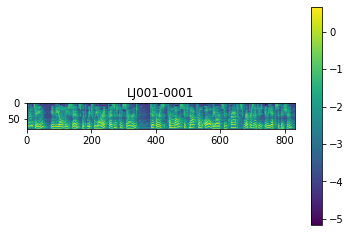

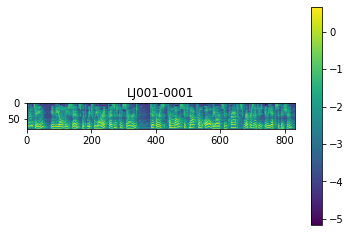

In [12]:
import kaldiio
import matplotlib.pyplot as plt

# load scp file
scp_dict = kaldiio.load_scp("fbank/raw_fbank_char_train.1.scp")
for key in scp_dict:
    plt.imshow(scp_dict[key].T[::-1])
    plt.title(key)
    plt.colorbar()
    plt.show()
    break
    
# load ark file
ark_generator = kaldiio.load_ark("fbank/raw_fbank_char_train.1.ark")
for key, array in ark_generator:
    plt.imshow(array.T[::-1])
    plt.title(key)
    plt.colorbar()
    plt.show()
    break

Some files are added in `data/train`:
- `feats.scp`: concatenated scp file of `fbank/raw_fbank_train.{1..4}.scp`.  
- `utt2num_frames`: Each line has `<utt_id> <number_of_frames>` .

In [16]:
!tree data/char_train

data/char_train
├── feats.scp
├── filetype
├── spk2utt
├── text
├── utt2num_frames
├── utt2spk
└── wav.scp

0 directories, 7 files


In [17]:
!head -n 3 data/char_train/*

==> data/char_train/feats.scp <==
LJ001-0001 /content/espnet/egs/ljspeech/tts1/fbank/raw_fbank_char_train.1.ark:11
LJ001-0002 /content/espnet/egs/ljspeech/tts1/fbank/raw_fbank_char_train.1.ark:67243
LJ001-0003 /content/espnet/egs/ljspeech/tts1/fbank/raw_fbank_char_train.1.ark:81035

==> data/char_train/filetype <==
mat

==> data/char_train/spk2utt <==
LJ LJ001-0001 LJ001-0002 LJ001-0003 LJ001-0004 LJ001-0005 LJ001-0006 LJ001-0007 LJ001-0008 LJ001-0009 LJ001-0010 LJ001-0011 LJ001-0012 LJ001-0013 LJ001-0014 LJ001-0015 LJ001-0016 LJ001-0017 LJ001-0018 LJ001-0019 LJ001-0020 LJ001-0021 LJ001-0022 LJ001-0023 LJ001-0024 LJ001-0025 LJ001-0026 LJ001-0027 LJ001-0028 LJ001-0029 LJ001-0030 LJ001-0031 LJ001-0032 LJ001-0033 LJ001-0034 LJ001-0035 LJ001-0036 LJ001-0037 LJ001-0038 LJ001-0039 LJ001-0040 LJ001-0041 LJ001-0042 LJ001-0043 LJ001-0044 LJ001-0045 LJ001-0046 LJ001-0047 LJ001-0048 LJ001-0049 LJ001-0050 LJ001-0051 LJ001-0052 LJ001-0053 LJ001-0054 LJ001-0055 LJ001-0056 LJ001-0057 LJ001-0058 LJ001

`data/train/` directory is split into two directories:
- `data/train_nodev/`: data directory for training
- `data/train_dev/`: data directory for validation


In [18]:
!tree data/char_train_*

data/char_train_no_dev
├── cmvn.ark
├── feats.scp
├── spk2utt
├── text
├── utt2num_frames
├── utt2spk
└── wav.scp

0 directories, 7 files


`cmvn.ark` is saved in `data/train_nodev`, which is the statistics file.  
(cepstral mean variance normalization: `cmvn`)  
This file also can be loaded in python via kaldiio.

In [21]:
!tree data/char_train_no_dev

data/char_train_no_dev
├── cmvn.ark
├── feats.scp
├── spk2utt
├── text
├── utt2num_frames
├── utt2spk
└── wav.scp

0 directories, 7 files


Normalized features for train, dev, and eval sets are dumped in
- `dump/{train_nodev,train_dev,test}/*.{ark,scp}`.  

These ark and scp can be loaded as the same as the above procedure.

In [20]:
!tree dump/*

dump/char_dev
├── feats.1.ark
├── feats.1.scp
├── feats.2.ark
├── feats.2.scp
├── feats.3.ark
├── feats.3.scp
├── feats.4.ark
├── feats.4.scp
├── feats.scp
├── filetype
└── utt2num_frames
dump/char_eval
├── feats.1.ark
├── feats.1.scp
├── feats.2.ark
├── feats.2.scp
├── feats.3.ark
├── feats.3.scp
├── feats.4.ark
├── feats.4.scp
├── feats.scp
├── filetype
└── utt2num_frames
dump/char_train_no_dev
├── feats.1.ark
├── feats.1.scp
├── feats.2.ark
├── feats.2.scp
├── feats.3.ark
├── feats.3.scp
├── feats.4.ark
├── feats.4.scp
├── feats.scp
├── filetype
└── utt2num_frames

0 directories, 33 files


### Stage 2: Dictionary and json preparation

This stage creates char dict and integrate files into a single json file.

<div align=center>
    <img src=https://github.com/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_tts/figs/tts_stage2.png?raw=1 width=80%>
</div>

In [22]:
# run stage 2 and then stop
!./run.sh --stage 2 --stop_stage 2

dictionary: data/lang_1char/char_train_no_dev_units.txt
stage 2: Dictionary and Json Data Preparation
33 data/lang_1char/char_train_no_dev_units.txt
/content/espnet/egs/ljspeech/tts1/../../../utils/data2json.sh --feat dump/char_train_no_dev/feats.scp --trans_type char data/char_train_no_dev data/lang_1char/char_train_no_dev_units.txt
/content/espnet/egs/ljspeech/tts1/../../../utils/feat_to_shape.sh --cmd run.pl --nj 1 --filetype  --preprocess-conf  --verbose 0 dump/char_train_no_dev/feats.scp data/char_train_no_dev/tmp-mPgka/input_1/shape.scp
/content/espnet/egs/ljspeech/tts1/../../../utils/data2json.sh --feat dump/char_dev/feats.scp --trans_type char data/char_dev data/lang_1char/char_train_no_dev_units.txt
/content/espnet/egs/ljspeech/tts1/../../../utils/feat_to_shape.sh --cmd run.pl --nj 1 --filetype  --preprocess-conf  --verbose 0 dump/char_dev/feats.scp data/char_dev/tmp-7Cp6T/input_1/shape.scp
/content/espnet/egs/ljspeech/tts1/../../../utils/data2json.sh --feat dump/char_eval/fea

- Dictionary file is created in `data/lang_1char/`.  
- Dictionary file consists of `<token>` `<token index>`.  
    - `<token index>` starts from 1 because 0 is used as padding index.


In [23]:
!tree data/lang_1char

data/lang_1char
└── char_train_no_dev_units.txt

0 directories, 1 file


In [26]:
!cat data/lang_1char/char_train_no_dev_units.txt

<unk> 1
! 2
' 3
, 4
. 5
<space> 6
? 7
A 8
B 9
C 10
D 11
E 12
F 13
G 14
H 15
I 16
J 17
K 18
L 19
M 20
N 21
O 22
P 23
Q 24
R 25
S 26
T 27
U 28
V 29
W 30
X 31
Y 32
Z 33


Three json files are created for train, dev, and eval sets as 
- `dump/{train_nodev,train_dev,test}/data.json`.

In [27]:
!tree dump -L 2

dump
├── char_dev
│   ├── data.json
│   ├── feats.1.ark
│   ├── feats.1.scp
│   ├── feats.2.ark
│   ├── feats.2.scp
│   ├── feats.3.ark
│   ├── feats.3.scp
│   ├── feats.4.ark
│   ├── feats.4.scp
│   ├── feats.scp
│   ├── filetype
│   ├── log
│   └── utt2num_frames
├── char_eval
│   ├── data.json
│   ├── feats.1.ark
│   ├── feats.1.scp
│   ├── feats.2.ark
│   ├── feats.2.scp
│   ├── feats.3.ark
│   ├── feats.3.scp
│   ├── feats.4.ark
│   ├── feats.4.scp
│   ├── feats.scp
│   ├── filetype
│   ├── log
│   └── utt2num_frames
└── char_train_no_dev
    ├── data.json
    ├── feats.1.ark
    ├── feats.1.scp
    ├── feats.2.ark
    ├── feats.2.scp
    ├── feats.3.ark
    ├── feats.3.scp
    ├── feats.4.ark
    ├── feats.4.scp
    ├── feats.scp
    ├── filetype
    ├── log
    └── utt2num_frames

6 directories, 36 files


Each json file contains all of the information in the data directory.

- `shape`: Shape of the input or output sequence.
- `text`: Original transcription.
- `token`: Token sequence of the transcription.
- `tokenid` Token id sequence converted with `dict` of the transcription

In [28]:
!head -n 27 dump/char_train_no_dev/data.json

{
    "utts": {
        "LJ001-0001": {
            "input": [
                {
                    "feat": "/content/espnet/egs/ljspeech/tts1/dump/char_train_no_dev/feats.1.ark:11",
                    "name": "input1",
                    "shape": [
                        832,
                        80
                    ]
                }
            ],
            "output": [
                {
                    "name": "target1",
                    "shape": [
                        151,
                        35
                    ],
                    "text": "PRINTING, IN THE ONLY SENSE WITH WHICH WE ARE AT PRESENT CONCERNED, DIFFERS FROM MOST IF NOT FROM ALL THE ARTS AND CRAFTS REPRESENTED IN THE EXHIBITION",
                    "token": "P R I N T I N G , <space> I N <space> T H E <space> O N L Y <space> S E N S E <space> W I T H <space> W H I C H <space> W E <space> A R E <space> A T <space> P R E S E N T <space> C O N C E R N E D , <space> D I F F E R S <space> F 

Now ready to start training!

### Stage 3: Network training

This stage trains E2E-TTS network.

<div align=center>
    <img src=https://github.com/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_tts/figs/tts_stage3.png?raw=1 width=80%>
</div>

Training setting can be specified by `train_config`.

In [29]:
# check hyperparmeters in run.sh
!head -n 31 run.sh | tail -n 2


# char or phn


Training configuration is written in `.yaml` format file.  
Let us check the default configuration `conf/train_pytroch_tacotron2.yaml`.

In [30]:
!cat conf/train_pytorch_tacotron2.yaml

# This configuration uses reduction factor = 1 and location-sensitive attention.
# Furthermore, to accelerate the learning of diaogonal attention, we additionaly
# use guided attention loss. This leads super fast and robust attention learning.

# encoder related
embed-dim: 512
elayers: 1
eunits: 512
econv-layers: 3 # if set 0, no conv layer is used
econv-chans: 512
econv-filts: 5

# decoder related
dlayers: 2
dunits: 1024
prenet-layers: 2  # if set 0, no prenet is used
prenet-units: 256
postnet-layers: 5 # if set 0, no postnet is used
postnet-chans: 512
postnet-filts: 5

# attention related
atype: location
adim: 128
aconv-chans: 32
aconv-filts: 15      # resulting in filter-size = aconv-filts * 2 + 1
cumulate-att-w: true # whether to cumulate attetion weight
use-batch-norm: true # whether to use batch normalization in conv layer
use-concate: true    # whether to concatenate encoder embedding with decoder lstm outputs
use-residual: false  # whether to use residual connection in encoder 

Let's change the hyperparameters.

In [31]:
# load configuration yaml
import yaml
with open("conf/train_pytorch_tacotron2.yaml") as f:
    params = yaml.load(f, Loader=yaml.Loader)

# change hyperparameters by yourself!
params.update({
    "embed-dim": 16,
    "elayers": 1, 
    "eunits": 16,
    "econv-layers": 1,
    "econv-chans": 16,
    "econv-filts": 5,
    "dlayers": 1,
    "dunits": 16,
    "prenet-layers": 1,
    "prenet-units": 16,
    "postnet-layers": 1,
    "postnet-chans": 16,
    "postnet-filts": 5,
    "adim": 16,
    "aconv-chans": 16,
    "aconv-filts": 5,
    "reduction-factor": 5,
    "batch-size": 128,
    "epochs": 5,
    "report-interval-iters": 10,
})

# save
with open("conf/train_pytorch_tacotron2_mini.yaml", "w") as f:
    yaml.dump(params, f, Dumper=yaml.Dumper)

# check modified version
!cat conf/train_pytorch_tacotron2_mini.yaml

aconv-chans: 16
aconv-filts: 5
adim: 16
atype: location
batch-size: 128
batch-sort-key: shuffle
bce-pos-weight: 1.0
cumulate-att-w: true
dlayers: 1
dropout-rate: 0.5
dunits: 16
econv-chans: 16
econv-filts: 5
econv-layers: 1
elayers: 1
embed-dim: 16
epochs: 5
eps: 1e-6
eunits: 16
guided-attn-loss-sigma: 0.4
lr: 1e-3
maxlen-in: 150
maxlen-out: 400
patience: 0
postnet-chans: 16
postnet-filts: 5
postnet-layers: 1
prenet-layers: 1
prenet-units: 16
reduction-factor: 5
report-interval-iters: 10
use-batch-norm: true
use-concate: true
use-guided-attn-loss: true
use-masking: true
use-residual: false
weight-decay: 0.0
zoneout-rate: 0.1


Also, we provide `transformer` and `fastspeech` configs.  

In [32]:
!cat ../../ljspeech/tts1/conf/tuning/train_pytorch_transformer.v1.yaml

# This configuration reuqires 3 gpus in the case of each gpu memory = 12GB, and it takes 3~4 days.
# If you cannot use 3 gpus, it is better to make batch-bins small, increase accum_grad and epochs.
# This model should be able to genearate speeech from around 40k iterations.

# network architecture related
model-module: espnet.nets.pytorch_backend.e2e_tts_transformer:Transformer
embed-dim: 0
eprenet-conv-layers: 0  # one more linear layer w/o non-linear will be added for 0-centor
eprenet-conv-filts: 0
eprenet-conv-chans: 0
dprenet-layers: 2  # one more linear layer w/o non-linear will be added for 0-centor
dprenet-units: 256
adim: 384
aheads: 4
elayers: 6
eunits: 1536
dlayers: 6
dunits: 1536
postnet-layers: 5
postnet-filts: 5
postnet-chans: 256
use-masking: True
bce-pos-weight: 5.0
use-batch-norm: True
use-scaled-pos-enc: True
encoder-normalize-before: False
decoder-normalize-before: False
encoder-concat-after: False
decoder-concat-after: False
reduction-factor: 1

# minibatch related
b

In [33]:
!cat ../../ljspeech/tts1/conf/tuning/train_fastspeech.v2.yaml

# This configuration reuqires 3 gpus in the case of each gpu memory = 12GB.
# To use this configuration, you need the model trained with `conf/tuning/train_transformer.v1`.
# First, you should train the above model or download from google drive and put it in exp dirctory.
# Make sure the `teacher-model` path is valid and the encoder structure is the same as teacher
# when `init-encoder-from-teacher = True`.
# This configuration uses Conv1d in Transformer blocks and aheads = 2 compared to v1.
# It takes 3~4 days, and it can generate speech from around 170 epochs (around 30k iters).

# network architecture related
model-module: espnet.nets.pytorch_backend.e2e_tts_fastspeech:FeedForwardTransformer
adim: 384
aheads: 2
elayers: 6
eunits: 1536
dlayers: 6
dunits: 1536
duration-predictor-layers: 2
duration-predictor-chans: 384
duration-predictor-kernel-size: 3
positionwise-layer-type: conv1d
positionwise-conv-kernel-size: 3
use-scaled-pos-enc: True
encoder-normalize-before: False
decoder-norma

We can easily switch the model to be trained by only changing `--train_config`.  
(NOTE: FastSpeech needs a teacher model, pretrained Transformer)

Let's train the network.  
You can specify the config file via `--train_config` option.  
It takes several minutes.

In [ ]:
# use modified configuration file as train config
!./run.sh --stage 3 --stop_stage 3 --train_config conf/train_pytorch_tacotron2_mini.yaml --verbose 1

dictionary: data/lang_1char/char_train_no_dev_units.txt
stage 3: Text-to-speech model training


You can see the training log in `exp/train_*/train.log`.

In [ ]:
!cat exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/train.log

The models are saved in `exp/train_*/results/` directory.

- `exp/train_*/results/model.loss.best`: contains only the model parameters.  
- `exp/train_*/results/snapshot.ep.*`: contains the model parameters, optimizer states, and iterator states. 

In [ ]:
!tree -L 1 exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results

`exp/train_*/results/*.png` are the figures of training curve.  
Let us check them.

In [ ]:
from IPython.display import Image, display_png
print("all loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results/all_loss.png", width=500))
print("l1 loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results/l1_loss.png", width=500))
print("mse loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results/mse_loss.png", width=500))
print("bce loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results/bce_loss.png", width=500))

`exp/train_*/results/att_ws/*.png` are the figures of attention weights in each epoch.  
In the case of E2E-TTS, it is very important to check that they are diagonal.

In [ ]:
print("Attention weights of initial epoch")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/results/att_ws/fash-cen1-b.ep.1.png", width=500))

Example of a good diagonal attention weights:
<div align=center>
    <img src=https://github.com/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_tts/figs/ex_attention_weights.png?raw=1 width=60%>
</div>
We should monitor whether the attention weight becomes like this figure.

Also, we support tensorboard.  
You can see the training log through tensorboard.

In [ ]:
# only available in colab
%load_ext tensorboard
%tensorboard --logdir tensorboard/train_nodev_pytorch_train_pytorch_tacotron2_mini/

### Stage 4: Network decoding

This stage performs decoding with trained model.

<div align=center>
    <img src=https://github.com/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_tts/figs/tts_stage4.png?raw=1 width=80%>
</div>

Decoding parameters can be specified by `--decode_config`.

In [ ]:
!head -n 32 run.sh | tail -n 1

Decoding configuration in written in `.yaml` format file.  
Let us check the default configuration `conf/decode.yaml`.

In [ ]:
!cat conf/decode.yaml

Let us modify to stop the generation in early steps.

In [ ]:
# load configuration yaml
import yaml
with open("conf/decode.yaml") as f:
    params = yaml.load(f, Loader=yaml.Loader)

# change hyperparameters by yourself!
params.update({
    "maxlenratio": 1.0,
})

# save
with open("conf/decode_mini.yaml", "w") as f:
    yaml.dump(params, f, Dumper=yaml.Dumper)

# check modified version
!cat conf/decode_mini.yaml

In [ ]:
# run stage 4 and then stop
!./run.sh --stage 4 --stop_stage 4 --nj 2 --verbose 1 \
    --train_config conf/train_pytorch_tacotron2_mini.yaml \
    --decode_config conf/decode_mini.yaml

Generated features are saved as `ark/scp` format.  
Also figures of attention weights and stop probabilities are saved as `{att_ws/probs}/*.png`.

In [ ]:
!tree -L 2 exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/outputs_model.loss.best_decode*

### Stage 5: Waveform synthesis

This stage synthesizes waveform with Griffin-Lim.

<div align=center>
    <img src=https://github.com/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_tts/figs/tts_stage5.png?raw=1 width=80%>
</div>

In [ ]:
# run stage 5 and then stop
!./run.sh --stage 5 --stop_stage 5 --nj 2 \
    --train_config conf/train_pytorch_tacotron2_mini.yaml \
    --decode_config conf/decode_mini.yaml \
    --griffin_lim_iters 4

Please run stage 5.

Generated wav files are saved in 
- `exp/train_nodev_pytorch_*/outputs_model.loss.best_*_denorm/{train_dev,test}/wav/`

In [ ]:
!tree -L 2 exp/train_nodev_pytorch_train_pytorch_tacotron2_mini/*_denorm

Now you finish building your own E2E-TTS model!

But unfortunately, this model cannot generate a good speech.  
Let us listen to the samples in demo HP to check the quality.  
https://espnet.github.io/espnet-tts-sample/

## 3. Demonstration of the use of TTS pretrained models

We provide pretrained TTS models and these are easy to use with `espnet/utils/synth_wav.sh`.

In [ ]:
# move on directory
os.chdir("../../librispeech/asr1")
!pwd

Let us check the usage of `espnet/utils/synth_wav.sh`.  
It will automatically downloads pretrained model from online, you do not need to prepare anything.  

In [ ]:
!../../../utils/synth_wav.sh --help

Let us generate your own text with pretrained models!

In [ ]:
# generate your sentence!
!rm -rf decode/example
print("Please input your favorite sentence!")
text = input()
text = text.upper()
with open("example.txt", "w") as f:
    f.write(text + "\n")

# you can change here to select the pretrained model
!../../../utils/synth_wav.sh --stop_stage 3 --models ljspeech.fastspeech.v1 example.txt
# !../../../utils/synth_wav.sh --stop_stage 3 --models ljspeech.tacotron2.v3 example.txt
# !../../../utils/synth_wav.sh --stop_stage 3 --models ljspeech.transformer.v1 example.txt

# check generated audio
from IPython.display import display, Audio, Image, display_png
display(Audio("decode/example/wav/example_1.wav"))
!sox decode/example/wav/example_1.wav -n rate 22050 spectrogram
display_png(Image("spectrogram.png", width=750))

# check attention and probs
if os.path.exists("decode/example/outputs/att_ws/example_1_att_ws.png"):
    display_png(Image("decode/example/outputs/att_ws/example_1_att_ws.png", width=1000))
    display_png(Image("decode/example/outputs/probs/example_1_prob.png", width=500))

Also you can try the neural vocoder.

In [ ]:
# generate your sentence!
!rm -rf decode/example_short
print("Please input your favorite sentence!")
text = input()
text = text.upper()
with open("example_short.txt", "w") as f:
    f.write(text + "\n")
    
# extend stop_stage
!../../../utils/synth_wav.sh --stop_stage 4 --models ljspeech.tacotron2.v3 example_short.txt

# check generated audio
display(Audio("decode/example_short/wav/example_short_1.wav"))
display(Audio("decode/example_short/wav_wnv/example_short_1_gen.wav"))

## 4. Demonstration of the use of ASR pretrained models

ESPnet also provides the `espnet/utils/recog_wav.sh` to use pretrained ASR models.  
Let us recognize the generated speech!

In [ ]:
!../../../utils/recog_wav.sh --help

In [ ]:
# downsample to 16 kHz for ASR model
!sox decode/example/wav/example_1.wav -b 16 decode/example/wav/example_1_16k.wav rate 16k pad 0.1 pad 0 0.1

# make decode config
import yaml
with open("conf/decode_sample.yaml", "w") as f:
    yaml.dump({
        "batchsize": 0,
        "beam-size": 5,
        "ctc-weight": 0.4,
        "lm-weight": 0.6,
        "maxlenratio": 0.0,
        "minlenratio": 0.0,
        "penalty": 0.0,
    }, f, Dumper=yaml.Dumper)

# let's recognize generated speech
!../../../utils/recog_wav.sh --models librispeech.transformer.v1 \
    --decode_config conf/decode_sample.yaml \
    decode/example/wav/example_1_16k.wav

## Conclusion

- Can build E2E-TTS models with unified-design recipe
- Can try various models by just changing the yaml file

Through ESPnet, you can build / use E2E-TTS and E2E-ASR in the same manner!

Thank you for your attention!

[*Go to the next notebook from here!*](https://colab.research.google.com/github/espnet/interspeech2019-tutorial/blob/master/notebooks/interspeech2019_asr/interspeech2019_asr.ipynb)